In [1]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import GridSearchCV

C:\Users\megha\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")


In [3]:
# Load the dataset
df=pd.read_csv(r"C:\Users\megha\OneDrive\Intellipaat\Machine_Learning\DataSet\AirPassengers.csv")

In [4]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [6]:
df["Month"]=pd.to_datetime(df["Month"])

In [7]:
df.index=df["Month"]
del df["Month"]


In [8]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<Axes: xlabel='Month'>

<Figure size 1000x1500 with 0 Axes>

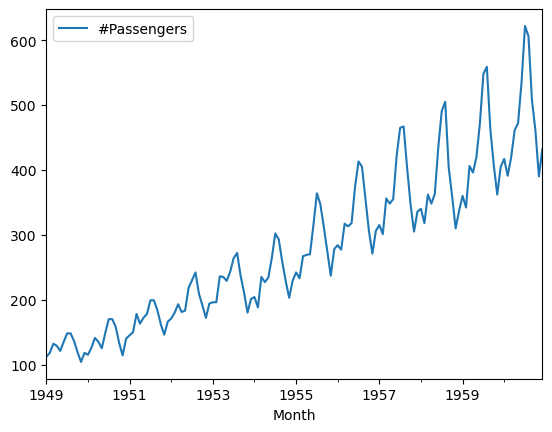

In [9]:
plt.figure(figsize=(10,15))
df.plot()

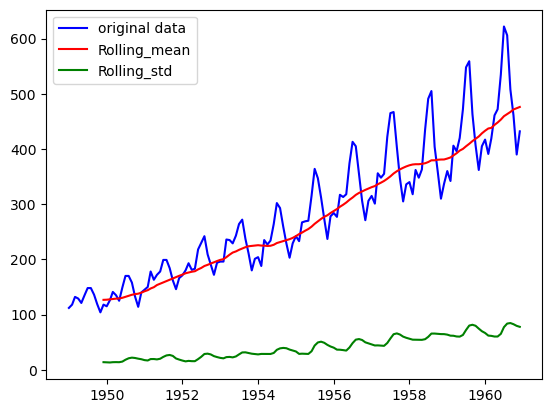

In [10]:
# Calculating rolling mean and standard deviation
mean_log=df.rolling(window=12).mean()
std_log=df.rolling(window=12).std()

# Plot rolling mean and std
plt.plot(df,color="blue",label="original data")
plt.plot(mean_log,color="red",label="Rolling_mean")
plt.plot(std_log,color="green",label="Rolling_std")
plt.legend()

In [11]:
# Perform Augmented Dickey-Fuller test for stationarity
result=adfuller(df["#Passengers"])
keys= ["test_statistics","p_value","num_logs","num_observations","critical_values","AIC"]

for key,values in zip(keys,result):
    print(f"{key}:{values}")

test_statistics:0.8153688792060352
p_value:0.9918802434376408
num_logs:13
num_observations:130
critical_values:{'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
AIC:996.692930839019


<Axes: xlabel='Month'>

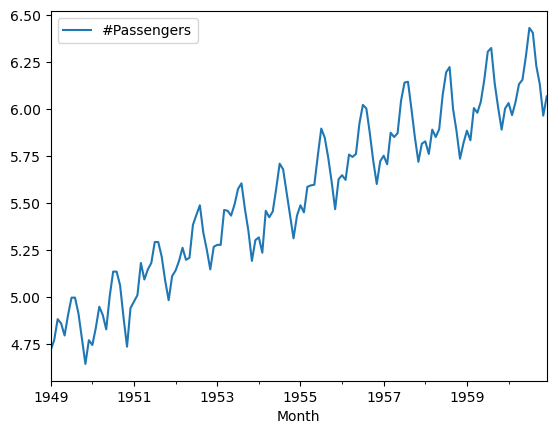

In [12]:
# Log transformation of data
first_log=np.log(df)
first_log=first_log.dropna()
first_log.plot()

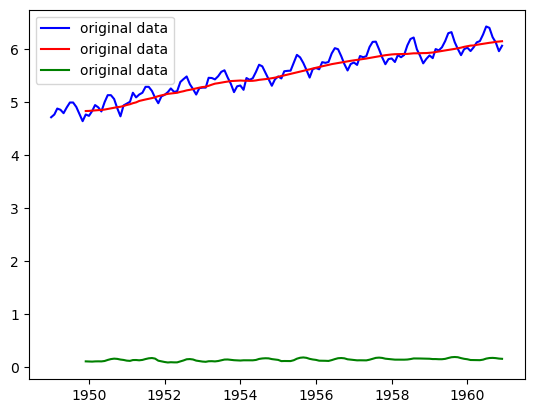

In [13]:
# Calculating rolling mean and standard deviation after log transformation
mean_log=first_log.rolling(window=12).mean()
std_log=first_log.rolling(window=12).std()

# Plot rolling mean and std
plt.plot(first_log,color="blue",label="original data")
plt.plot(mean_log,color="red",label="original data")
plt.plot(std_log,color="green",label="original data")
plt.legend()

In [14]:
# Detrending the Data by Removing the Rolling Mean
new_data=first_log-mean_log
new_data=new_data.dropna()

In [15]:
# Perform Augmented Dickey-Fuller test for stationarity
result=adfuller(new_data["#Passengers"])
keys= ["test_statistics","p_value","num_logs","num_observations","critical_values","AIC"]

for key,values in zip(keys,result):
    print(f"{key}:{values}")

test_statistics:-3.1629079913008704
p_value:0.022234630001243053
num_logs:13
num_observations:119
critical_values:{'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}
AIC:-436.63269481747034


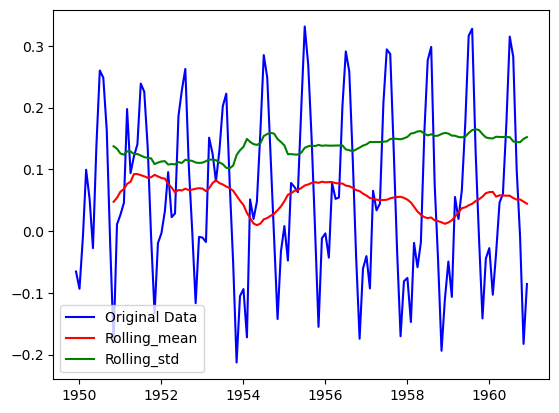

In [16]:
# Calculating rolling mean and standard deviation after detrending
mean_log=new_data.rolling(window=12).mean()
std_log=new_data.rolling(window=12).std()
plt.plot(new_data,color="blue",label="Original Data")
plt.plot(mean_log,color="red",label="Rolling_mean")
plt.plot(std_log,color="green",label="Rolling_std")
plt.legend()

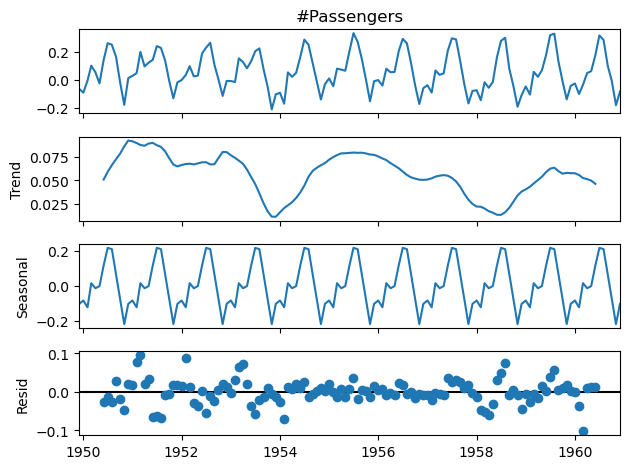

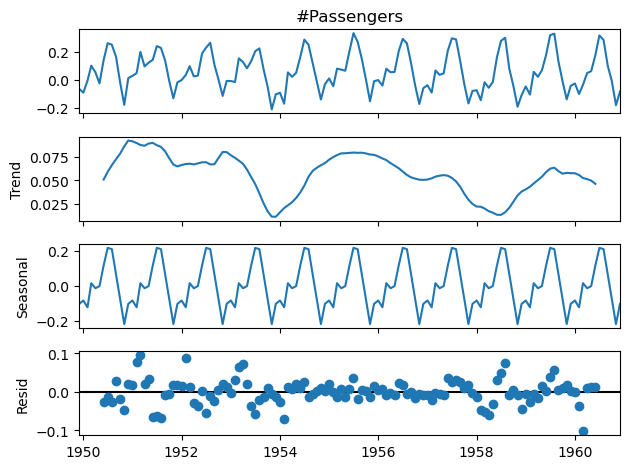

In [17]:
# Decompose time series

from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result= seasonal_decompose(new_data["#Passengers"].dropna())
decompose_result.plot()

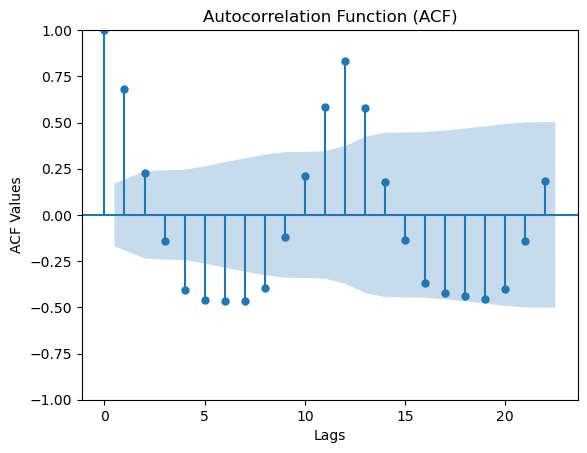

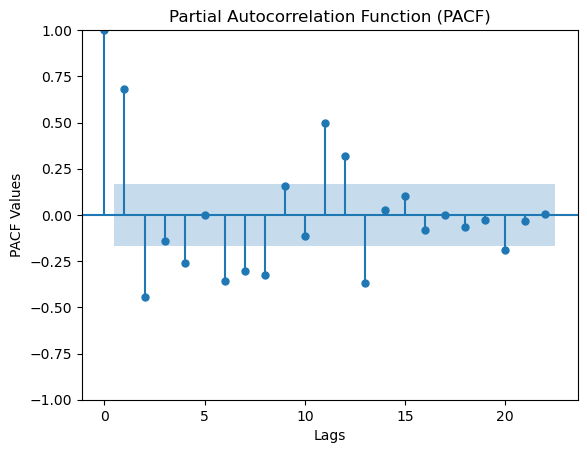

In [18]:
# Autocorrelation and Partial Autocorrelation Analysis

acf_values=acf(new_data)
plot_acf(new_data)
plt.title("Autocorrelation Function (ACF)") 
plt.xlabel("Lags")  
plt.ylabel("ACF Values") 
plt.show()

pacf_values=pacf(new_data,nlags=10)
plot_pacf(new_data)
plt.title("Partial Autocorrelation Function (PACF)") 
plt.xlabel("Lags")  
plt.ylabel("PACF Values") 
plt.show()  

In [19]:
# Splitting data set
train=new_data.iloc[:120]["#Passengers"]
test=new_data.iloc[120:]

In [20]:
# Building and Fitting the ARIMAX Model

model=ARIMA(train,order=(1,0,2))
model_fit=model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  120
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 117.901
Date:                Mon, 20 Jan 2025   AIC                           -225.803
Time:                        20:14:57   BIC                           -211.865
Sample:                    12-01-1949   HQIC                          -220.143
                         - 11-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0538      0.022      2.446      0.014       0.011       0.097
ar.L1          0.4323      0.318      1.361      0.173      -0.190       1.055
ma.L1          0.5917      0.323      1.829      0.0

<Axes: xlabel='Month'>

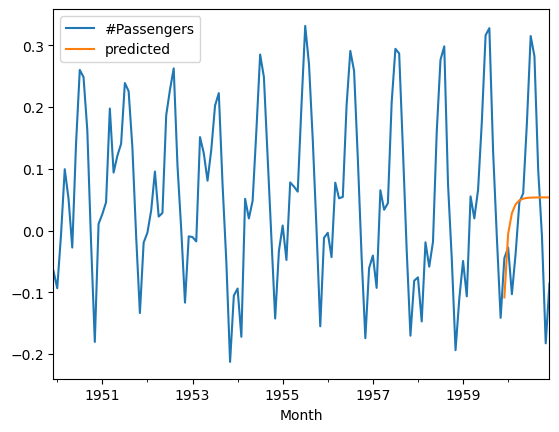

In [21]:
# Predictions on Test Data and Visualization

new_data["predicted"]=model_fit.predict(start=len(train),end=len(train)+len(test)-1,dynamic=True)
new_data[["#Passengers","predicted"]].plot()

In [22]:
# Grid search for optimal ARIMA parameters
p = d = q = range(0, 5)  
pdq = list(itertools.product(p, d, q))  
best_aic = float("inf")
best_params = None
best_model = None

# Grid Search for ARIMA
for param in pdq:
    try:
        model = ARIMA(train, order=param)  
        results = model.fit()
        if results.aic < best_aic:  # Compare AIC values
            best_aic = results.aic
            best_params = param
            best_model = results
    except:
        continue

print(f"Best ARIMA Parameters: {best_params}")
print(f"Best AIC: {best_aic}")

Best ARIMA Parameters: (2, 0, 3)
Best AIC: -279.7328429377122


In [23]:
# Building and Fitting the ARIMAX Model
model=ARIMA(train,order=(2,0,3))
model_fit=model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  120
Model:                 ARIMA(2, 0, 3)   Log Likelihood                 146.866
Date:                Mon, 20 Jan 2025   AIC                           -279.733
Time:                        20:16:11   BIC                           -260.220
Sample:                    12-01-1949   HQIC                          -271.809
                         - 11-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0549      0.009      6.359      0.000       0.038       0.072
ar.L1          1.7319      0.010    167.103      0.000       1.712       1.752
ar.L2         -0.9943      0.009   -105.434      0.0

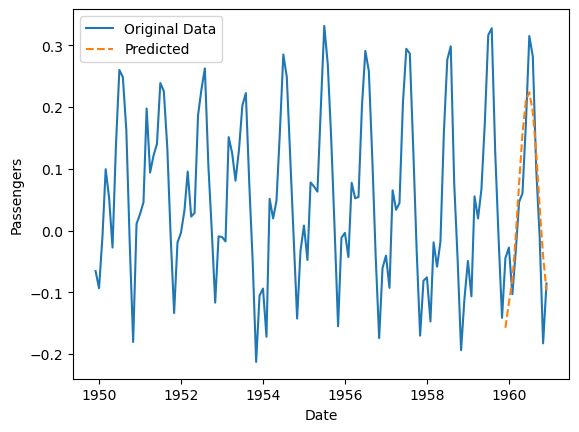

In [24]:
# Predictions on Test Data and Visualization
new_data["predicted"]=model_fit.predict(start=len(train),end=len(train)+len(test)-1,dynamic=True)

plt.plot(new_data["#Passengers"],label="Original Data")
plt.plot(new_data["predicted"],label="Predicted",linestyle="--")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()

In [25]:
# Building and Fitting the SARIMAX Model

model=SARIMAX(train,order=(1,0,2),seasonal_order=(1,0,2,12))
model_fit=model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  120
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                 220.461
Date:                            Mon, 20 Jan 2025   AIC                           -426.922
Time:                                    20:16:15   BIC                           -407.410
Sample:                                12-01-1949   HQIC                          -418.998
                                     - 11-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4765      0.194      2.455      0.014       0.096       0.857
ma.L1          0.1294      0.189   

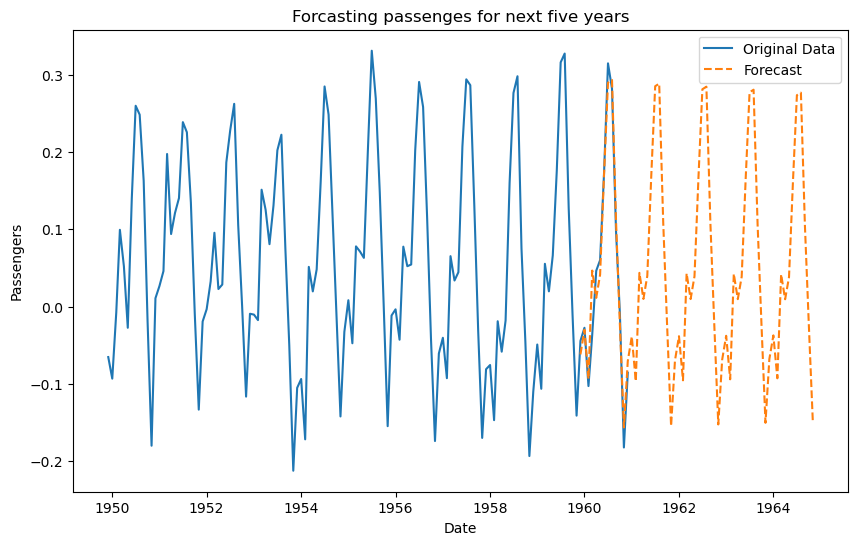

In [26]:
# Making Predictions and Plotting the Forecast
forecast=model_fit.forecast(steps=60)

plt.figure(figsize=(10,6))
plt.plot(new_data.index,new_data["#Passengers"],label="Original Data")
plt.plot(forecast.index,forecast,label="Forecast",linestyle="--")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.title("Forcasting passenges for next five years")
plt.legend()